# Análise de Sentimento

A análise de sentimento é uma área do processamento de linguagem natural que tem por objetivo extrair, quantifica e estudar de maneira sistemática os sentimentos expressos através de dados representados através de texto.

Uma das abordagens mais utilizadas para realizar análise de sentimento é a classficação de sentimento, que consiste em associar um documento a uma determinada emoção automaticamente. Uma classificação tradicional é a das categorias positiva e negativa para sentimentos.

Nesse caderno realizaremos duas análises de sentimentos. A primeira será realizada sobre um corpus de tweets e a segunda será uma demonstração de uso da TextBlob para análise de sentimento.

# 1. Análise de tweets

## 1.1 Importando base e instalando pacotes

In [ ]:
# Instalando pacotes necessários
!pip install nlp
import nlp

     |████████████████████████████████| 1.7 MB 24.6 MB/s 
     |████████████████████████████████| 243 kB 59.1 MB/s 


In [ ]:
# Baixando dataset que será usado
# Mais detalhes sobre o dataset podem ser encontrados em https://www.kaggle.com/kazanova/sentiment140
dataset = nlp.load_dataset('sentiment140')

Downloading:   0%|          | 0.00/4.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/81.4M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset sentiment140 downloaded and prepared to /root/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/2ad0bb6460a543b63240b86e18ec4b50cd40dd36f3d72ded82a9d695d34548d1. Subsequent calls will reuse this data.


In [ ]:
# Dando uma olhada no corpus
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'date': Value(dtype='string', id=None), 'user': Value(dtype='string', id=None), 'sentiment': Value(dtype='int32', id=None), 'query': Value(dtype='string', id=None)}, num_rows: 498),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'date': Value(dtype='string', id=None), 'user': Value(dtype='string', id=None), 'sentiment': Value(dtype='int32', id=None), 'query': Value(dtype='string', id=None)}, num_rows: 1600000)}

Veja que o corpus já está divido em datasets de treino e de teste.

## 1.2 Análise Exploratória de Dados

In [ ]:
# Quantidade de linhas para treino e teste
print(dataset['train'].num_rows)
print(dataset['test'].num_rows)

1600000
498


In [ ]:
# Importando as bibliotecas matplotlib e seaborn
import matplotlib.pyplot as plt
import seaborn as sns

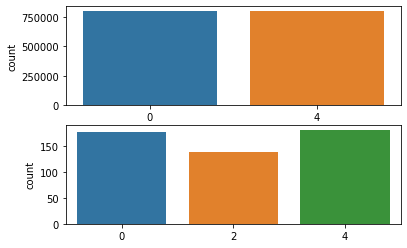

In [ ]:
# Visualizando distribuição de categorias da variável alvo nos dois dataframes
fig, axs = plt.subplots(2)
sns.countplot(x = dataset['train']['sentiment'], ax = axs[0])
sns.countplot(x = dataset['test']['sentiment'], ax = axs[1])

Nossa variável alvo possui uma escala que vai de 0 (negativo), passa pelo 2 (neutro) e chega até o 4 (positivo).

## 1.3 Uso do NLTK para pré-processamento

In [ ]:
# A NLTK possui um tokenizador especial para tweets, o TweetTokenizer
# Vamos importar esse tokenizador
from nltk.tokenize import TweetTokenizer

In [ ]:
# Criando objeto tokenizador
# preserve_case - mantém maiúsculas
# reduce_len - remove duplicações
tokenizador = TweetTokenizer(preserve_case=False, reduce_len=True)

In [ ]:
# Comparação de texto original com tokenziado
print(dataset['train']['text'][0])
print(tokenizador.tokenize(dataset['train']['text'][0]))

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
['@switchfoot', 'http://twitpic.com/2y1zl', '-', 'awww', ',', "that's", 'a', 'bummer', '.', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', '.', ';D']


## 1.4 Criação de representação por Matriz Termo Documento

Vamos usar uma matriz termo documento para representar de maneira vetorial os documentos. A representação de cada documento está relacionado a termos naqueles documentos. A similaridade entre documentos é calculada a partir da distância entre os vetores de representação dos documentos.

Passos para criar matriz termo documento:
1. Vamos trabalhar só com 10% da base de treino por questão de custo computacional.
2. Criar matriz com frequência absoluta de termos.
3. Devido ao corpus muito grande só vamos manter tokens com mais de 30 aparições.


In [ ]:
# Importando biblioteca random
import random

In [ ]:
# Definindo seed que usaremos
random.seed(42)

In [ ]:
# Pegando 10% das linhas da base aleatoriamente usando ao seed
amostra = random.sample(list(range(dataset['train'].num_rows)),k=int(0.1*dataset['train'].num_rows))

In [ ]:
# Pegando as colunas com tweets e com os sentimentos
tweets_treino = [dataset['train'][i]['text'] for i in amostra]
sentimento = [dataset['train'][i]['sentiment'] for i in amostra]

In [ ]:
# Importando vetorizador
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Criando objeto vetorizador e o valorando
# min_df - tokens que aparecem no mínimo 30 vezes
vetorizador = CountVectorizer(tokenizer=tokenizador.tokenize, stop_words='english', min_df=30)
contador = vetorizador.fit_transform(tweets_treino)

In [ ]:
# Visualizando matriz de representação
contador

<160000x3874 sparse matrix of type '<class 'numpy.int64'>'
	with 1091918 stored elements in Compressed Sparse Row format>

## 1.5 Criando representação via TF-IDF

In [ ]:
# Importando representação TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Criando objeto vetorizador e o valorando
vetorizador_tfidf = TfidfVectorizer(tokenizer=tokenizador.tokenize, stop_words='english', min_df=30)
tfidf = vetorizador_tfidf.fit_transform(tweets_treino)

In [ ]:
# Olhando representação criada
tfidf

<160000x3874 sparse matrix of type '<class 'numpy.float64'>'
	with 1091918 stored elements in Compressed Sparse Row format>

## 1.6 Visualizando diferenças de matrizes

As dimensões das duas matrizes são as mesmas, porém, uma armazena a frequência absoluta dos termos e a outra armazena o logaritmo da frequência ponderada pelo inverso da frequência no corpus inteiro. Vamos dar uma olhada na diferença de escalas dos valores contidos nas duas contagens.

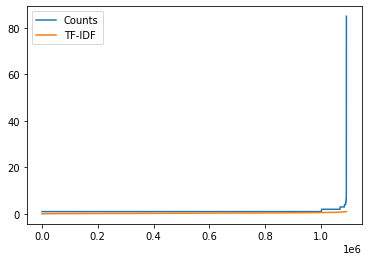

In [ ]:
# Visualizando diferença graficamente
plt.plot(sorted(contador.data),label="Counts")
plt.plot(sorted(tfidf.data),label="TF-IDF")
plt.legend()

"Como pode ser observado no gráfico, para a contagem simples alguns termos muito frequentes têm valores maiores que 80 (o que pode ser considerado bem alto, considerando que um tweet tem 140 caracteres). Já a contagem TF-IDF tem valores menores, devido à ponderação logaritmica dos termos e o fator multiplicativo da frequência inversa em todos os documentos."

## 1.7 Treinando modelo floresta aleatória

In [ ]:
# Importando algoritmo de floresta aleatória
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Criando objeto com modelo de floresta aleatória e treinando ele com a representação de contador
floresta_contador = RandomForestClassifier(n_estimators=100, random_state=42)
floresta_contador.fit(contador, sentimento)

RandomForestClassifier(random_state=42)

In [ ]:
# Criando objeto com modelo de floresta aleatória e treinando ele com a representação de TF-IDF
floresta_TFIDF = RandomForestClassifier(n_estimators=100, random_state=42)
floresta_TFIDF.fit(tfidf, sentimento)

RandomForestClassifier(random_state=42)

## 1.8 Termos mais importantes em cada modelo

In [ ]:
# Encontrando as 20 palavras mais influentes na classificação
top_palavras = 20
importancia_palavras_contador = floresta_contador.feature_importances_.argsort()[-top_palavras:]
importancia_palavras_tfidf = floresta_TFIDF.feature_importances_.argsort()[-top_palavras:]

In [ ]:
# Importando nparray que será utilizado para visualizar as palavras mais importantes
import numpy as np

In [ ]:
# Mostrando as 20 palavras mais importantes do modelo de contador (crescente)
np.array(vetorizador.get_feature_names())[importancia_palavras_contador]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['just', 'want', 'thank', 'sick', 'bad', "can't", 'sorry', '...',
       'hate', 'wish', 'work', 'good', 'love', '?', ',', 'thanks', '.',
       'miss', 'sad', '!'], dtype='<U21')

In [ ]:
# Mostrando as 20 palavras mais importantes do modelo de TFIDF (crescente)
np.array(vetorizador_tfidf.get_feature_names())[importancia_palavras_tfidf]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['sick', "i'm", 'want', 'bad', 'just', "can't", 'sorry', 'hate',
       'wish', 'work', 'love', 'good', '...', '?', 'thanks', ',', 'miss',
       'sad', '.', '!'], dtype='<U21')

## 1.9 Criação de pipeline e avaliação do desempenho dos modelos

In [ ]:
# Importando pacotes de pipeline e métricas
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, classification_report

**Descrição de um pipeline no scikit-learn:**
Pipeline of transforms with a final estimator. Sequentially apply a list of transforms and a final estimator. Intermediate steps of the pipeline must be ‘transforms’, that is, they must implement fit and transform methods. The final estimator only needs to implement fit. The transformers in the pipeline can be cached using memory argument. The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. 

In [ ]:
# Definindo pipeline para modelo de contador
pipeline_contador = Pipeline([
    ('vet_cont', vetorizador),
    ('floresta_modelo', floresta_contador)
])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


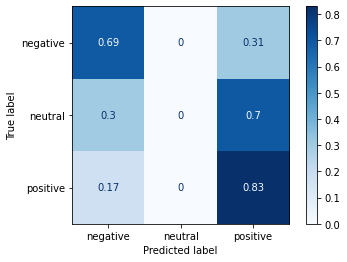

In [ ]:
# Plotando matriz de confusão do modelo do contador
plot_confusion_matrix(pipeline_contador, dataset['test']['text'], dataset['test']['sentiment'],
                                 display_labels=['negative','neutral','positive'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')

In [ ]:
# Avaliação de métricas
print(classification_report(dataset['test']['sentiment'],
                            pipeline_contador.predict(dataset['test']['text'])
                            ,zero_division=0))

              precision    recall  f1-score   support

           0       0.63      0.69      0.66       177
           2       0.00      0.00      0.00       139
           4       0.50      0.83      0.62       182

    accuracy                           0.55       498
   macro avg       0.38      0.51      0.43       498
weighted avg       0.41      0.55      0.46       498



In [ ]:
# Repetindo o processo acima para o modelo TF-IDF
pipeline_tfidf = Pipeline([
    ('vet_tfidf', vetorizador_tfidf),
    ('floresta_modelo', floresta_TFIDF)
])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


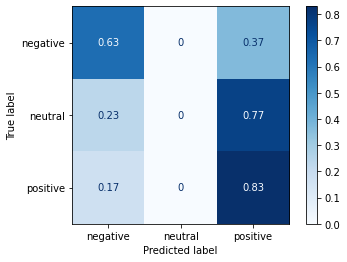

In [ ]:
plot_confusion_matrix(pipeline_tfidf, dataset['test']['text'], dataset['test']['sentiment'],
                                 display_labels=['negative','neutral','positive'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')

In [ ]:
print(classification_report(dataset['test']['sentiment'], 
                            pipeline_tfidf.predict(dataset['test']['text']),
                            zero_division=0))

              precision    recall  f1-score   support

           0       0.64      0.63      0.64       177
           2       0.00      0.00      0.00       139
           4       0.47      0.83      0.60       182

    accuracy                           0.53       498
   macro avg       0.37      0.49      0.41       498
weighted avg       0.40      0.53      0.44       498



# 2. Análise de sentimento através da TextBlob

A TextBlob é uma biblioteca simples que oferece diversos recursos para PLN, como análise de sentimentos, correção ortográfico, etc. O analisador de sentimentos da TextBlob retorna duas propriedades para uma determinada frase de entrada:

* **Polaridade:** Define positividade ou negatividade de um texto, retornando um valor entre -1 e 1, sendo 1 um sentimento positivo e -1 um sentimento negativo.
* **Subjetividade:** Define subjetividade ou objetividade de um texto, retorna um valor entre 0 e 1, sendo 0 muito subjetivo e 1 muito objetivo. 

## 2.1 Importando bibliotecas

In [ ]:
# Importando as bibliotecas usadas
import nltk
from textblob import TextBlob

## 2.2 Testes rápidos da análise de sentimento da TextBlob

In [ ]:
sentiment_1 = TextBlob("The food was great!")
print(sentiment_1.sentiment)

Sentiment(polarity=1.0, subjectivity=0.75)


In [ ]:
sentiment_2 = TextBlob("I hate Cars")
print(format(sentiment_2.sentiment))

Sentiment(polarity=-0.8, subjectivity=0.9)


In [ ]:
sentiment_3 = TextBlob("I am travelling")
print(format(sentiment_3.sentiment))

Sentiment(polarity=0.0, subjectivity=0.0)


In [ ]:
sentiment_4 = TextBlob("I hate monday")
print(format(sentiment_4.sentiment))

Sentiment(polarity=-0.8, subjectivity=0.9)


In [ ]:
sentiment_5 = TextBlob("I love California")
print(format(sentiment_5.sentiment))

Sentiment(polarity=0.5, subjectivity=0.6)


In [ ]:
sentiment_6 = TextBlob("I hate monday but I love California")
print(format(sentiment_6.sentiment))

Sentiment(polarity=-0.15000000000000002, subjectivity=0.75)


In [ ]:
sentiment_7 = TextBlob("I love monday but I hate California")
print(format(sentiment_7.sentiment))

Sentiment(polarity=-0.15000000000000002, subjectivity=0.75)


In [ ]:
sentiment_8 = TextBlob("Miss Universe is beautiful")
print(format(sentiment_8.sentiment))

Sentiment(polarity=0.85, subjectivity=1.0)
